# Results Collation
Contains manipulation of raw data and the statistical analysis performed to produce the results section of the paper.

## Setup

### Get data from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
data_folder = "drive/MyDrive/Project Data"
os.chdir(data_folder)
os.listdir()

['Evaluation of Cross Device Interactions (1).xlsx',
 'Demographic Questionnaire.xlsx',
 'csv',
 'FreeCAD Logs',
 'subjectMatter.png',
 'CPUS.png']

### Setup Data Frames

In [27]:
import pandas as pd
import numpy as np


demographics = pd.read_excel("Demographic Questionnaire.xlsx")
d_cols_to_drop = ['Entry_DateUpdated', 'Entry_DateSubmitted', 'Entry_DateCreated', 'Entry_Status', 'DemographicQuestionnaire_Id']
demographics = demographics.drop(d_cols_to_drop, axis='columns')


survey = pd.read_excel("Evaluation of Cross Device Interactions (1).xlsx")
columns = survey.columns


sus_columns = columns[1:21]
sus_ratings = survey[sus_columns[1::2]]
sus_responses = survey[sus_columns[::2]]

cpus_columns = columns[21:37]
cpus_ratings = survey[cpus_columns[1::2]]
cpus_responses = survey[cpus_columns[::2]]

text_response_columns = columns[37:43]
text_responses = survey[text_response_columns]

subject_matter_columns = columns[43:57]
subject_matter_ratings = survey[subject_matter_columns[1::2]]
subject_matter_responses = survey[subject_matter_columns[::2]]

### Helper Functions

In [69]:
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import sqrt, pow


cmap = plt.get_cmap('tab20c')
colour_dict = {
    'Strongly Agree': cmap(1),
    'Agree': cmap(2),
    'Neutral': cmap(17),
    'Disagree': cmap(6),
    'Strongly Disagree': cmap(5)
}


def create_significant_correlation_matrix(df):
    correlation, pvalue = spearmanr(df)
    columns = [f'Question {i}' for i in range(1, len(df.columns)+1)]
    correlation_df = pd.DataFrame(correlation, columns, columns)
    pvalue_df = pd.DataFrame(pvalue, columns, columns)
    significant_df = correlation_df[(pvalue_df < 0.05)]
    return significant_df


def print_value_count(dataframe):
    for c in dataframe.columns:
        print("\n---- %s ---" % c)
        print(dataframe[c].value_counts())


# System Usability Scoring
def calculate_sus(row):
    bool_check = True
    total = 0
    learn = 0
    use = 0
    for i in range(1, 11):
        if bool_check:
            total += row[i] - 1
        else:
            total += 5 - row[i]
        if i in (4,10):
            if bool_check:
                learn += row[i] - 1
            else:
                learn += 5 - row[i]
        else:
            if bool_check:
                use += row[i] - 1
            else:
                use += 5 - row[i]
        bool_check = False
    return (total * 2.5, learn * 2.5, use * 2.5)


def print_latex_table(questions, df):
    for i in range(len(questions)):
        series = df.iloc[:, i]
        series = series.value_counts()
        sta = series.get('Strongly Agree', 0)
        a = series.get('Agree', 0)
        n = series.get('Neutral', 0)
        d = series.get('Disagree', 0)
        std = series.get('Strongly Disagree', 0)
        index = list(series.index)
        print(f'{questions[i]} & {sta} & {a} & {n} & {d} & {std} \\\\')


def standard_deviation(values):
    population = len(values)
    mean = sum(values)/population
    return sqrt(sum([pow(i - mean, 2) for i in values])/population)

## Demographics

In [43]:
print_value_count(demographics)


---- WhatAgeAreYou ---
21-25    8
51-60    1
61+      1
Name: WhatAgeAreYou, dtype: int64

---- HowWouldYouIdentifyYourGender ---
Female    5
Male      5
Name: HowWouldYouIdentifyYourGender, dtype: int64

---- HaveYouUsedCADComputerAidedDesignBefore ---
Yes    5
No     5
Name: HaveYouUsedCADComputerAidedDesignBefore, dtype: int64

---- HaveYouEverUsedFreeCAD ---
No    5
Name: HaveYouEverUsedFreeCAD, dtype: int64

---- HowOftenDoYouUseCAD2 ---
Even less than that    3
Yearly                 2
Name: HowOftenDoYouUseCAD2, dtype: int64

---- HaveYouKnowinglyUsedCrossDeviceInteractionBefore ---
Yes    5
No     5
Name: HaveYouKnowinglyUsedCrossDeviceInteractionBefore, dtype: int64

---- HowOftenDoYouUseCrossDeviceInteraction ---
Weekly                 2
Monthly                2
Even less than that    1
Name: HowOftenDoYouUseCrossDeviceInteraction, dtype: int64


## SUS

In [73]:
sus_scores = np.array([calculate_sus(row) for row in sus_ratings.itertuples()])  # Cast to numpy array to allow simple slicing

total = sum(sus_scores[:, 0])
learnability = sum(sus_scores[:, 1])
usability = sum(sus_scores[:, 2])

s_deviation = standard_deviation(sus_scores[:, 0])

print(f'Mean score:   {total/10}\nSD: {s_deviation:.2f}\nLearnability: {learnability/10}\nUsability:    {usability/10}')

Mean score:   52.25
SD: 4.80
Learnability: 13.75
Usability:    38.5


In [36]:
# Format data for Latex table per user
i = 1
for result in sus_scores:
    print(f'{i} & {result[0]} & {result[1]} & {result[2]} \\\\')
    i += 1

1 & 55.0 & 15.0 & 40.0 \\
2 & 60.0 & 20.0 & 40.0 \\
3 & 57.5 & 17.5 & 40.0 \\
4 & 50.0 & 15.0 & 35.0 \\
5 & 50.0 & 7.5 & 42.5 \\
6 & 50.0 & 10.0 & 40.0 \\
7 & 55.0 & 17.5 & 37.5 \\
8 & 45.0 & 10.0 & 35.0 \\
9 & 45.0 & 10.0 & 35.0 \\
10 & 55.0 & 15.0 & 40.0 \\


Users that had usability issues: 4,7,8,9 \\
Users that had learning issues: 5,6,8,9

In [44]:
questions = [
    'I think that I would like to use this system frequently.',
    'I found the system unnecessarily complex.',
    'I thought the system was easy to use.',
    'I think that I would need the support of a technical person to be able to use this system.',
    'I found the various functions in this system were well integrated.',
    'I thought there was too much inconsistency in this system.',
    'I would imagine that most people would learn to use this system very quickly.',
    'I found the system very cumbersome to use.',
    'I felt very confident using the system.',
    'I needed to learn a lot of things before I could get going with this system.'
 ]


# List questions for Latex
for question in questions:
    print(f'\\item {question}')

print('-------------')

# Create formatted table for Latex per question
print_latex_table(questions, sus_responses)

\item I think that I would like to use this system frequently.
\item I found the system unnecessarily complex.
\item I thought the system was easy to use.
\item I think that I would need the support of a technical person to be able to use this system.
\item I found the various functions in this system were well integrated.
\item I thought there was too much inconsistency in this system.
\item I would imagine that most people would learn to use this system very quickly.
\item I found the system very cumbersome to use.
\item I felt very confident using the system.
\item I needed to learn a lot of things before I could get going with this system.
-------------
I think that I would like to use this system frequently. & 0 & 4 & 6 & 0 & 0\\
I found the system unnecessarily complex. & 0 & 0 & 1 & 3 & 6\\
I thought the system was easy to use. & 5 & 4 & 1 & 0 & 0\\
I think that I would need the support of a technical person to be able to use this system. & 0 & 1 & 2 & 5 & 2\\
I found the variou

In [53]:
# Create the correlation matrix where the correlation is statistically significant
create_significant_correlation_matrix(sus_ratings)

,Question 1,Question 2,Question 3,Question 4,Question 5,Question 6,Question 7,Question 8,Question 9,Question 10
Question 1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Question 2,NaN,1.000000,-0.862582,NaN,NaN,NaN,NaN,NaN,-0.692935,NaN
Question 3,NaN,-0.862582,1.000000,NaN,NaN,NaN,NaN,NaN,0.699868,NaN
Question 4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Question 5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Question 6,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Question 7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Question 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Question 9,NaN,-0.692935,0.699868,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
Question 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## CPUS

In [42]:
questions = [
    'I felt productive when using both devices.',
    'I felt that the user interfaces cross-device needed much improvement.',
    'It was easy to use each user interface.',
    'I found the various functions cross-platform were well integrated.',
    'I needed to learn how to use each user interface separately.',
    'I was frustrated by the different designs of each user interface.',
    'I am satisfied with the amount of time it took to resume the task I started from before, when moving between devices.',
    'I found I needed to remember information from the user interface on the laptop to be able to continue with the task using the user interface on the mobile device.'
 ]


# List questions for Latex
for question in questions:
    print(f'\\item {question}')

print('-------------')

# Create formatted table for Latex
print_latex_table(questions, cpus_responses)

I felt productive when using both devices. & 2 & 5 & 3 & 0 & 0 \\
I felt that the user interfaces cross-device needed much improvement. & 0 & 1 & 1 & 5 & 3 \\
It was easy to use each user interface. & 5 & 4 & 1 & 0 & 0 \\
I found the various functions cross-platform were well integrated. & 5 & 5 & 0 & 0 & 0 \\
I needed to learn how to use each user interface separately. & 1 & 1 & 2 & 4 & 2 \\
I was frustrated by the different designs of each user interface. & 0 & 0 & 0 & 4 & 6 \\
I am satisfied with the amount of time it took to resume the task I started from before, when moving between devices. & 4 & 5 & 1 & 0 & 0 \\
I found I needed to remember information from the user interface on the laptop to be able to continue with the task using the user interface on the mobile device. & 0 & 0 & 1 & 2 & 7 \\


In [54]:
# Create the correlation matrix where the correlation is statistically significant
create_significant_correlation_matrix(cpus_ratings)

,Question 1,Question 2,Question 3,Question 4,Question 5,Question 6,Question 7,Question 8
Question 1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Question 2,NaN,1.000000,-0.637832,-0.715581,NaN,NaN,NaN,NaN
Question 3,NaN,-0.637832,1.000000,NaN,NaN,NaN,NaN,NaN
Question 4,NaN,-0.715581,NaN,1.000000,NaN,NaN,NaN,0.645497
Question 5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Question 6,NaN,NaN,NaN,NaN,NaN,1.000000,-0.707107,NaN
Question 7,NaN,NaN,NaN,NaN,NaN,-0.707107,1.000000,NaN
Question 8,NaN,NaN,NaN,0.645497,NaN,NaN,NaN,1.000000


## Subject Matter Questions

In [41]:
questions = [
    "Did you feel that the Augmented Reality allowed you to better visualise the models in the real world?",
    "Would you use this to let others view your models?",
    "Would you have preferred using an app on the phone to view the model in AR?",
    "If you were using CAD would you appreciate being able to use this tool?",
    "Did you think that using more than one device to view your model enhanced your experience?",
    "Did you find moving your focus between devices distracting?",
]


# List questions for Latex
for question in questions:
    print(f'\\item {question}')

print('-------------')

# Create formatted table for Latex
print_latex_table(questions, subject_matter_responses)

\item Did you feel that the Augmented Reality allowed you to better visualise the models in the real world?
\item Would you use this to let others view your models?
\item Would you have preferred using an app on the phone to view the model in AR?
\item If you were using CAD would you appreciate being able to use this tool?
\item Did you think that using more than one device to view your model enhanced your experience?
\item Did you find moving your focus between devices distracting?
-------------
Did you feel that the Augmented Reality allowed you to better visualise the models in the real world? & 6 & 1 & 2 & 1 & 0\\
Would you use this to let others view your models? & 8 & 2 & 0 & 0 & 0\\
Would you have preferred using an app on the phone to view the model in AR? & 2 & 3 & 3 & 2 & 0\\
If you were using CAD would you appreciate being able to use this tool? & 5 & 5 & 0 & 0 & 0\\
Did you think that using more than one device to view your model enhanced your experience? & 4 & 4 & 1 & 1 & 

In [52]:
# Create the correlation matrix where the correlation is statistically significant
create_significant_correlation_matrix(subject_matter_ratings)

,Question 1,Question 2,Question 3,Question 4,Question 5,Question 6,Question 7
Question 1,1.000000,0.738281,NaN,NaN,0.807948,NaN,NaN
Question 2,0.738281,1.000000,NaN,NaN,NaN,NaN,NaN
Question 3,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Question 4,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Question 5,0.807948,NaN,NaN,NaN,1.000000,NaN,NaN
Question 6,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Question 7,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## Generating Graphs

### SUS

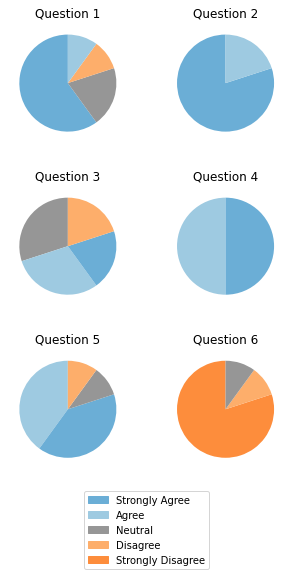

In [60]:
fig, axes = plt.subplots(3,2)

column_series = [survey_ratings[column] for column in survey_ratings]

titles = [['1','2'],['3','4'],['5','6']]

for j in [0,1,2]:
    for i in range(len(column_series[:6])//3):
        if j == 1:
            series = column_series[i+2]
        elif j == 2:
            series = column_series[i+4]
        else:
            series = column_series[i]
        series = series.value_counts()
        index = list(series.index)
        colours = [colour_dict[i] for i in index]
        axes[j][i].pie(series.values, startangle=90, colors=colours)
        axes[j][i].set_title(f'Question {titles[j][i]}')
plt.subplots_adjust(wspace=0.3, hspace=0)
fig.set_figheight(9)
fig.set_figwidth(5)
colour_patches = [mpatches.Patch(color=value, label=key) for key,value in colour_dict.items()]
fig.legend(handles=colour_patches, loc='lower center')
fig.savefig('SUS.png', bbox_inches='tight')
plt.show()

### CPUS

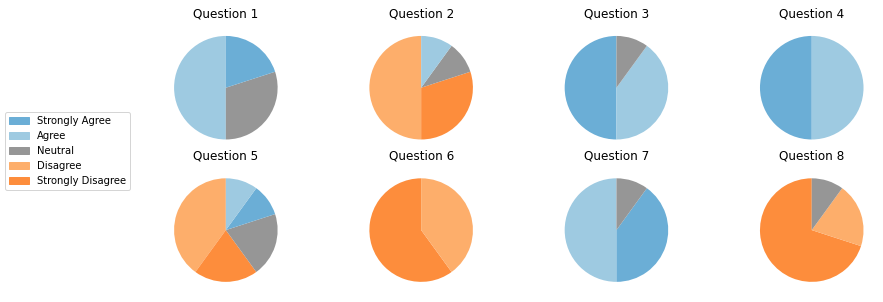

In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, axes = plt.subplots(2,4)

column_series = [cpus_responses[column] for column in cpus_responses]

titles = [['1','2','3','4'],['5','6','7','8']]

for j in [0,1]:
    for i in range(len(column_series)//2):
        if j == 1:
            series = column_series[i+4]
        else:
            series = column_series[i]
        series = series.value_counts()
        index = list(series.index)
        colours = [colour_dict[i] for i in index]
        axes[j][i].pie(series.values, startangle=90, colors=colours)
        axes[j][i].set_title(f'Question {titles[j][i]}')
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.set_figheight(5)
fig.set_figwidth(14)
colour_patches = [mpatches.Patch(color=value, label=key) for key,value in colour_dict.items()]
fig.legend(handles=colour_patches, loc='center left')
fig.savefig('CPUSpie.png', bbox_inches='tight')
plt.show()

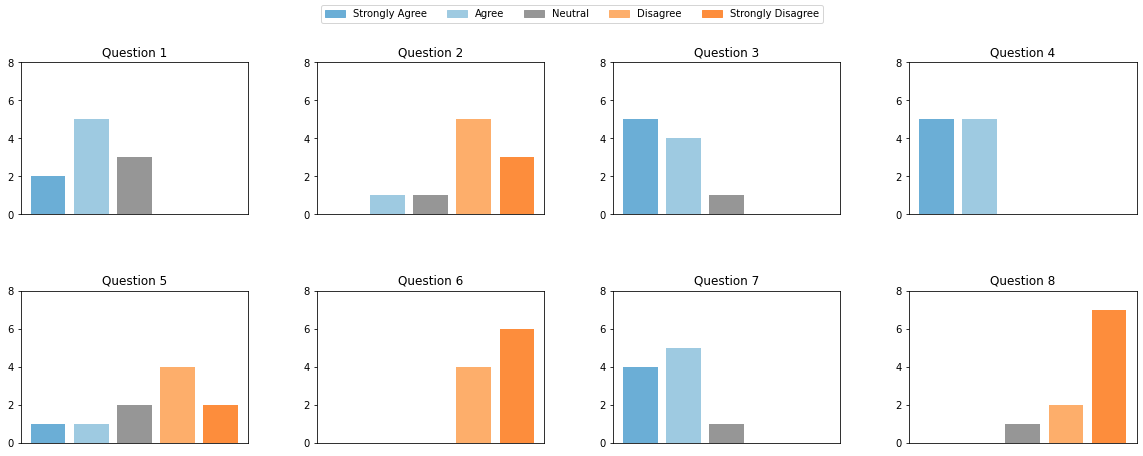

In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, axes = plt.subplots(2,4)

column_series = [cpus_responses[column] for column in cpus_responses]

titles = [['1','2','3','4'],['5','6','7','8']]

for j in [0,1]:
    for i in range(len(column_series)//2):
        if j == 1:
            series = column_series[i+4]
        else:
            series = column_series[i]
        series = series.value_counts()
        sta = series.get('Strongly Agree', 0)
        a = series.get('Agree', 0)
        n = series.get('Neutral', 0)
        d = series.get('Disagree', 0)
        std = series.get('Strongly Disagree', 0)
        axes[j][i].bar(np.arange(5), height=[sta, a, n, d, std], color=colour_dict.values())#, tick_label=list(colour_dict.keys()))
        axes[j][i].set_ylim(top=8)
        axes[j][i].set_title(f'Question {titles[j][i]}')
        axes[j][i].set_xticks([])
        # axes[j][i].tick_params('x', labelrotation=45)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
fig.set_figheight(7)
fig.set_figwidth(20)
colour_patches = [mpatches.Patch(color=value, label=key) for key,value in colour_dict.items()]
fig.legend(handles=colour_patches, loc='upper center', ncol=5)
fig.savefig('CPUS.png', bbox_inches='tight')
plt.show()

### Subject Matter

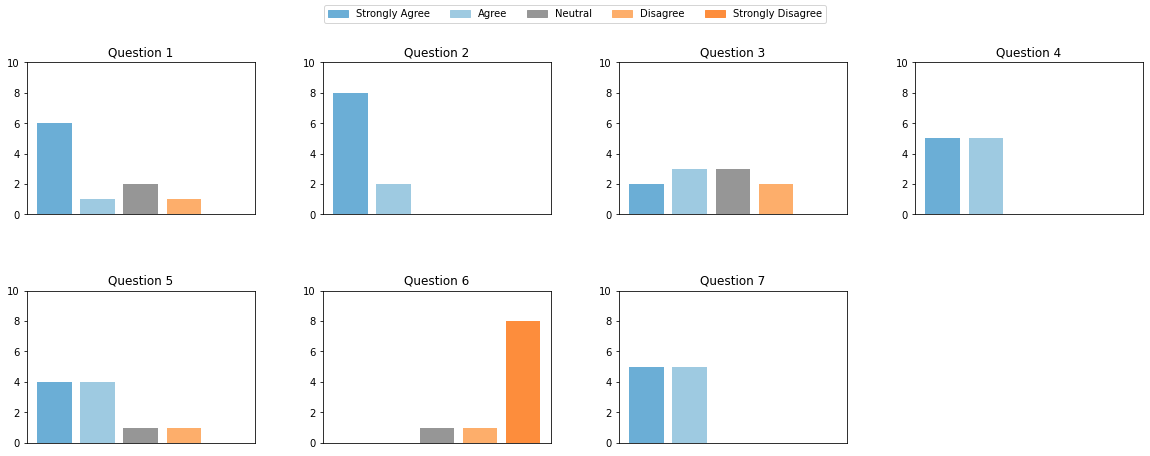

In [59]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, axes = plt.subplots(2,4)

column_series = [subject_matter_responses[column] for column in subject_matter_responses]

titles = [['1','2','3','4'],['5','6','7']]

for j in [0,1]:
    for i in range(len(titles[j])):
        if j == 1:
            series = column_series[i+4]
        else:
            series = column_series[i]
        series = series.value_counts()
        sta = series.get('Strongly Agree', 0)
        a = series.get('Agree', 0)
        n = series.get('Neutral', 0)
        d = series.get('Disagree', 0)
        std = series.get('Strongly Disagree', 0)
        axes[j][i].bar(np.arange(5), height=[sta, a, n, d, std], color=colour_dict.values())#, tick_label=list(colour_dict.keys()))
        axes[j][i].set_ylim(top=10)
        axes[j][i].set_title(f'Question {titles[j][i]}')
        axes[j][i].set_xticks([])
        # axes[j][i].tick_params('x', labelrotation=45)
axes[1, 3].axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.5)
fig.set_figheight(7)
fig.set_figwidth(20)
colour_patches = [mpatches.Patch(color=value, label=key) for key,value in colour_dict.items()]
fig.legend(handles=colour_patches, loc='upper center', ncol=5)
fig.savefig('subjectMatter.png', bbox_inches='tight')
plt.show()

# Phone Analysis
This has been discarded as the resulting plots are unusable

In [ ]:
# import modules
import pandas as pd
import numpy as np
from numpy import sin,cos,pi
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('seaborn')
# import data from CSV
df = pd.read_csv('csv/Test.csv', sep=';')
df.columns

Index(['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)',
       'ACCELEROMETER Z (m/s²)', 'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)',
       'GRAVITY Z (m/s²)', 'LINEAR ACCELERATION X (m/s²)',
       'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',
       'GYROSCOPE X (rad/s)', 'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)',
       'LIGHT (lux)', 'MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)',
       'MAGNETIC FIELD Z (μT)', 'ORIENTATION Z (azimuth °)',
       'ORIENTATION X (pitch °)', 'ORIENTATION Y (roll °)', 'PROXIMITY (i)',
       'LOCATION Latitude : ', 'LOCATION Longitude : ',
       'LOCATION Altitude ( m)', 'LOCATION Altitude-google ( m)',
       'LOCATION Speed ( Kmh)', 'LOCATION Accuracy ( m)',
       'LOCATION ORIENTATION (°)', 'Satellites in range',
       'Time since start in ms ', 'YYYY-MO-DD HH-MI-SS_SSS'],
      dtype='object')

In [ ]:
df = pd.DataFrame.copy(df[abs(df['ACCELEROMETER X (m/s²)'])>0.2])
df.columns

Index(['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)',
       'ACCELEROMETER Z (m/s²)', 'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)',
       'GRAVITY Z (m/s²)', 'LINEAR ACCELERATION X (m/s²)',
       'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',
       'GYROSCOPE X (rad/s)', 'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)',
       'LIGHT (lux)', 'MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)',
       'MAGNETIC FIELD Z (μT)', 'ORIENTATION Z (azimuth °)',
       'ORIENTATION X (pitch °)', 'ORIENTATION Y (roll °)', 'PROXIMITY (i)',
       'LOCATION Latitude : ', 'LOCATION Longitude : ',
       'LOCATION Altitude ( m)', 'LOCATION Altitude-google ( m)',
       'LOCATION Speed ( Kmh)', 'LOCATION Accuracy ( m)',
       'LOCATION ORIENTATION (°)', 'Satellites in range',
       'Time since start in ms ', 'YYYY-MO-DD HH-MI-SS_SSS',
       'EARTH ACCELERATION X', 'EARTH ACCELERATION Y', 'EARTH ACCELERATION Z',
       'EARTH GRAVITY X', 'EARTH GRAVITY Y', 'EARTH GRAVITY Z',
       'EA

In [ ]:
# Take a look at all sensor outputs
df.plot(subplots=True,sharex=True,layout=(6,6))
plt.show()

TypeError: ignored

In [ ]:
# Convert orientation measurement units to radians
cols_angles = ['ORIENTATION X (pitch °)','ORIENTATION Y (roll °)',
               'ORIENTATION Z (azimuth °)']
for axis in cols_angles:
    df[axis] = df[axis] * pi/180
# Transform body frame accelerations into the inertial (Earth) frame
    # Set up rotation matrices
def R_x(x):
    # body frame rotation about x axis
    return np.array([[1,      0,       0],
                     [0,cos(-x),-sin(-x)],
                     [0,sin(-x), cos(-x)]])
def R_y(y):
    # body frame rotation about y axis
    return np.array([[cos(-y),0,-sin(-y)],
                    [0,      1,        0],
                    [sin(-y), 0, cos(-y)]])
def R_z(z):
    # body frame rotation about z axis
    return np.array([[cos(-z),-sin(-z),0],
                     [sin(-z), cos(-z),0],
                     [0,      0,       1]])
# Set up arrays to hold acceleration data for transformation
accel = np.array([df['ACCELEROMETER X (m/s²)'],
                  df['ACCELEROMETER Y (m/s²)'],
                  df['ACCELEROMETER Z (m/s²)']])
grav = np.array([df['GRAVITY X (m/s²)'],
                 df['GRAVITY Y (m/s²)'],
                 df['GRAVITY Z (m/s²)']])
line = np.array([df['LINEAR ACCELERATION X (m/s²)'],
                 df['LINEAR ACCELERATION Y (m/s²)'],
                 df['LINEAR ACCELERATION Z (m/s²)']])
# Set up arrays to hold Euler angles for rotation matrices
pitch = df['ORIENTATION X (pitch °)']
roll = df['ORIENTATION Y (roll °)']
yaw = df['ORIENTATION Z (azimuth °)']
# Initilize arrays for new transformed accelerations
earth_accels = np.empty(accel.shape)
earth_gravity = np.empty(accel.shape)
earth_linear = np.empty(accel.shape)
# Perform frame transformations (body frame --> earth frame) 
for i in range(df.shape[0]):
    # accel_earth = (RzRyRx)(accel_body)
    earth_accels[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ accel[:,i]
    earth_gravity[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ grav[:,i]
    earth_linear[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ line[:,i]
# Create new columns in dataframe for earth frame accelerations    
df['EARTH ACCELERATION X'] = earth_accels[0,:]
df['EARTH ACCELERATION Y'] = earth_accels[1,:]
df['EARTH ACCELERATION Z'] = earth_accels[2,:]
df['EARTH GRAVITY X'] = earth_gravity[0,:]
df['EARTH GRAVITY Y'] = earth_gravity[1,:]
df['EARTH GRAVITY Z'] = earth_gravity[2,:]
df['EARTH LINEAR ACCELERATION X'] = earth_linear[0,:]
df['EARTH LINEAR ACCELERATION Y'] = earth_linear[1,:]
df['EARTH LINEAR ACCELERATION Z'] = earth_linear[2,:]

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning: When passing multiple axes, layout keyword is ignored
  "When passing multiple axes, layout keyword is ignored", UserWarning
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


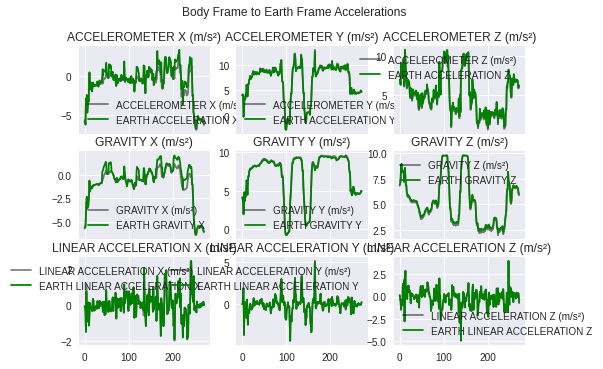

In [ ]:
# Plot new accelerations
cols_earth = ['EARTH ACCELERATION X','EARTH ACCELERATION Y',
              'EARTH ACCELERATION Z','EARTH GRAVITY X','EARTH GRAVITY Y','EARTH GRAVITY Z','EARTH LINEAR ACCELERATION X','EARTH LINEAR ACCELERATION Y','EARTH LINEAR ACCELERATION Z']
cols_body = ['ACCELEROMETER X (m/s²)','ACCELEROMETER Y (m/s²)',
             'ACCELEROMETER Z (m/s²)', 'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)','GRAVITY Z (m/s²)', 'LINEAR ACCELERATION X (m/s²)',
 'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)']
bodyplot = df.plot(y=cols_body,subplots=True,sharex=True,layout=(3,3),style='k',alpha=0.5,title=cols_body)
df.plot(y=cols_earth,subplots=True,layout=(3,3),ax=bodyplot,
sharex=True,style='g',
title='Body Frame to Earth Frame Accelerations')
plt.show()

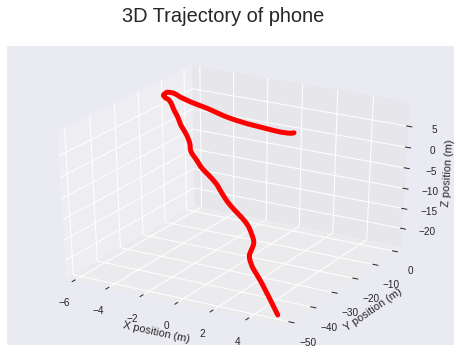

In [ ]:
dt = 0.1
# Double integrate accelerations to find positions
x =cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION X'],dx=dt),dx=dt)
y =cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION Y'],dx=dt),dx=dt)
z =cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION Z'],dx=dt),dx=dt)
# Plot 3D Trajectory
fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of phone',fontsize=20)
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z,c='red',lw=5,label='phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
plt.show()

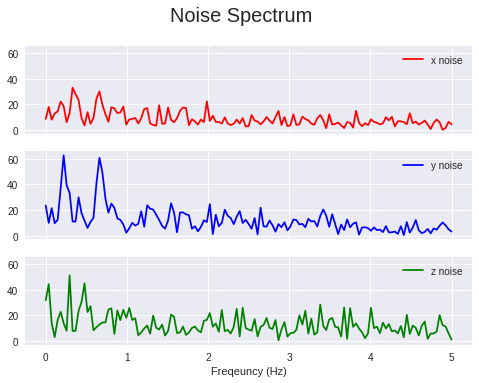

In [ ]:
# Try to remove noise via Fourier analysis
    # Discrete Fourier Transform sample frequencies
freq = np.fft.rfftfreq(df['EARTH LINEAR ACCELERATION X'].size,d=dt)
# Compute the Fast Fourier Transform (FFT) of acceleration signals
fft_x = np.fft.rfft(df['EARTH LINEAR ACCELERATION X']) 
fft_y = np.fft.rfft(df['EARTH LINEAR ACCELERATION Y']) 
fft_z = np.fft.rfft(df['EARTH LINEAR ACCELERATION Z'])
# Plot Frequency spectrum
fig4,[ax1,ax2,ax3] = plt.subplots(3,1,sharex=True,sharey=True)
fig4.suptitle('Noise Spectrum',fontsize=20)
ax1.plot(freq,abs(fft_x),c='r',label='x noise')
ax1.legend()
ax2.plot(freq,abs(fft_y),c='b',label='y noise')
ax2.legend()
ax3.plot(freq,abs(fft_z),c='g',label='z noise')
ax3.legend()
ax3.set_xlabel('Freqeuncy (Hz)')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning: When passing multiple axes, layout keyword is ignored
  "When passing multiple axes, layout keyword is ignored", UserWarning
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


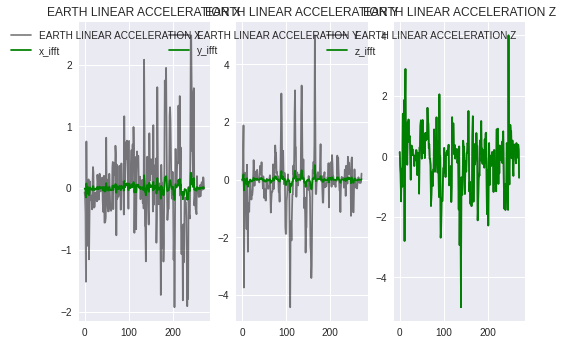

In [ ]:
# Attenuate noise in X,Y below 10Hz by 10 dB
# Attenuate noise <10Hz and >5Hz in Z axis by 10 dB
atten_x_fft = np.where(freq < 10,fft_x * 0.1, fft_x) 
atten_y_fft = np.where(freq < 10,fft_y * 0.1, fft_y) 
atten_z_fft = np.where((freq > 5) & (freq < 10),fft_z * 0.1, fft_z) 
# Compute inverse of discrete Fourier Transform 
df['x_ifft'] = np.fft.irfft(atten_x_fft,n=df.shape[0])
df['y_ifft'] = np.fft.irfft(atten_y_fft,n=df.shape[0])
df['z_ifft'] = np.fft.irfft(atten_z_fft,n=df.shape[0])
# Plot new acceleration signals
cols_raw = ['EARTH LINEAR ACCELERATION X','EARTH LINEAR ACCELERATION Y','EARTH LINEAR ACCELERATION Z']
cols_new = ['x_ifft','y_ifft','z_ifft']
rawplot = df.plot(y=cols_raw,subplots=True,sharex=True,layout=(1,3),
style='k',title=cols_raw,alpha=0.5)
df.plot(y=cols_new,subplots=True,layout=(1,3),ax=rawplot,
sharex=True,style='g')
plt.show()

In [ ]:
# Double integrate accelerations to calculate coordinate positions
x = cumtrapz(cumtrapz(df['x_ifft'],dx=dt),dx=dt)
y = cumtrapz(cumtrapz(df['y_ifft'],dx=dt),dx=dt)
z = cumtrapz(cumtrapz(df['z_ifft'],dx=dt),dx=dt)
# Plot attenuated 3D Trajectory
ax.plot3D(x,y,z,'k',lw=5,label='Attenuated phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.legend(fontsize='x-large')
plt.show()

In [ ]:
# Add XYZ axis arrows to indicate phone pose
    # Earth 3 axis unit vectors
earth_x = np.array([[1,0,0],]*len(x)).T
earth_y = np.array([[0,1,0],]*len(x)).T
earth_z = np.array([[0,0,1],]*len(x)).T
# Initialize body Vectors
body_x = np.empty(earth_x.shape)
body_y = np.empty(earth_y.shape)
body_z = np.empty(earth_z.shape)
# Perform inverse frame transformations (body frame <-- earth frame) 
    # body_vectors = (RxRyRz)(earth_vectors)
for i in range(x.shape[0]):
    # use negative angles to reverse rotation
    body_x[:,i] = R_x(-pitch[i]) @ R_y(-roll[i]) @ R_z(-yaw[i]) @earth_x[:,i]
    body_y[:,i] = R_x(-pitch[i]) @ R_y(-roll[i]) @ R_z(-yaw[i]) @ earth_y[:,i]
    body_z[:,i] = R_x(-pitch[i]) @ R_y(-roll[i]) @ R_z(-yaw[i]) @ earth_z[:,i]

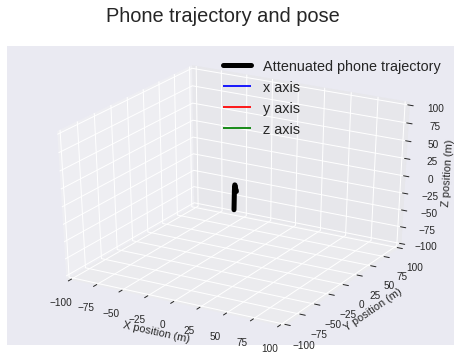

In [ ]:
# Set length of quiver arrows    
distance = np.sqrt(x[-1]**2 + y[-1]**2 + z[-1]**2)
length = 0.00005 * distance
# Plot x vectors
    # downsampling to every 10th arrow ([::10])
fig6,ax4 = plt.subplots()
fig6.suptitle('Phone trajectory and pose',fontsize=20)
ax4 = plt.axes(projection='3d')
ax4.plot3D(x,y,z,'k',lw=5,label='Attenuated phone trajectory')
# plot x vectors
ax4.quiver(x[::10],y[::10],z[::10],
          body_x[0][::10],body_x[1][::10],body_x[2][::10],
          color='b',label = 'x axis',length = length)
# Plot y vectors
ax4.quiver(x[::10],y[::10],z[::10],
          body_y[0][::10],body_y[1][::10],body_y[2][::10],
          color='r',label = 'y axis',length = length)
# Plot Z vectors
ax4.quiver(x[::10],y[::10],z[::10],
          body_z[0][::10],body_z[1][::10],body_z[2][::10],
          color='g',label = 'z axis',length = length)
ax4.set_xlabel('X position (m)')
ax4.set_ylabel('Y position (m)')
ax4.set_zlabel('Z position (m)')
ax4.set_xlim(-100,100)# may need to vary
ax4.set_ylim(-100,100)
ax4.set_zlim(-100,100)
ax4.legend(fontsize='x-large')
plt.show()